# Filling gaps - merged dataset - 1 sequence input
---
The notebook contains the code used in the process of preparing datasets and training neural network models with differing architecture, in order to analyse their capabilities in filling gaps present in aminoacid sequences.

---
Import necessary libraries.

In [11]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from keras.layers import (Bidirectional, Dense, Flatten, GRU, LSTM)
from keras.models import Sequential
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.optimizers.legacy import Adam

---
Function to put gaps in sequences (detailed description in the [Data_preparation](https://github.com/HPorada/aMLoid/blob/main/Data_preparation.ipynb) notebook).

In [2]:
def gap_sequences(column, gaps, repeat=1):
  inds = []
  seqs = []
  gapped = []

  for i in range(repeat):
    for seq in column:
      seqs.append(seq)
      inds = [i for i, _ in enumerate(seq)]

      samp = random.sample(inds, gaps)

      for index in samp:
        seq = seq[:index] + "_" + seq[index + 1:]

      gapped.append(seq)

  return seqs, gapped

---
Function to perform one-hot encoding on sequences (detailed description in the [Data_preparation](https://github.com/HPorada/aMLoid/blob/main/Data_preparation.ipynb) notebook).

In [3]:
char_to_int = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6,
               'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12,
               'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18,
               'Y': 19, '_': 20}

def one_hot_encoding(seqs, length=1):
  n_rows = len(seqs)
  max_seq_len = max(len(seqs[i]) for i in range(n_rows))
  max_len = max(max_seq_len, length)
  n_classes = len(char_to_int)

  encoded = np.zeros((n_rows, max_len, n_classes))

  for i in range(n_rows):
      seq = seqs[i]
      for j, letter in enumerate(seq):
        encoded[i, j, char_to_int[letter.upper()]] = 1

  return encoded

---
Functions returning different neural network structures analysed in the project (detailed description in chapter 4). They accept dimensions of input datasets as arguments.

In [4]:
def dense_1_model(sequence_length, num_amino_acids):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=sequence_length, activation='relu', input_shape=(sequence_length, num_amino_acids,)))
    model.add(keras.layers.Dense(units=num_amino_acids, activation='softmax'))
    return model

def dense_2_model(sequence_length, num_amino_acids):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=sequence_length, activation='relu', input_shape=(sequence_length, num_amino_acids,)))
    model.add(keras.layers.Dense(units=64, activation='relu'))
    model.add(keras.layers.Dense(units=num_amino_acids, activation='softmax'))
    return model

def dense_3_model(sequence_length, num_amino_acids):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=sequence_length, activation='relu', input_shape=(sequence_length, num_amino_acids,)))
    model.add(keras.layers.Dense(units=64, activation='relu'))
    model.add(keras.layers.Dense(units=32, activation='relu'))
    model.add(keras.layers.Dense(units=num_amino_acids, activation='softmax'))
    return model

def LSTM_1_model(sequence_length, num_amino_acids):
    model = Sequential()
    model.add(LSTM(units=sequence_length, input_shape=(sequence_length, num_amino_acids), return_sequences=True))
    model.add(Dense(num_amino_acids, activation='softmax'))
    return model

def LSTM_2_model(sequence_length, num_amino_acids):
    model = Sequential()
    model.add(LSTM(units=sequence_length, input_shape=(sequence_length, num_amino_acids), return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dense(num_amino_acids, activation='softmax'))
    return model

def LSTM_3_model(sequence_length, num_amino_acids):
    model = Sequential()
    model.add(LSTM(units=sequence_length, input_shape=(sequence_length, num_amino_acids), return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dense(num_amino_acids, activation='softmax'))
    return model

def bidirectional_LSTM_model(sequence_length, num_amino_acids):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=sequence_length, input_shape=(sequence_length, num_amino_acids), return_sequences=True)))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dense(num_amino_acids, activation='softmax'))
    return model

def GRU_1_model(sequence_length, num_amino_acids):
    model = Sequential()
    model.add(GRU(128, input_shape=(sequence_length, num_amino_acids), return_sequences=True))
    model.add(Dense(num_amino_acids, activation='softmax'))
    return model

def GRU_2_model(sequence_length, num_amino_acids):
    model = Sequential()
    model.add(GRU(128, input_shape=(sequence_length, num_amino_acids), return_sequences=True))
    model.add(GRU(64, return_sequences=True))
    model.add(Dense(num_amino_acids, activation='softmax'))
    return model

def GRU_3_model(sequence_length, num_amino_acids):
    model = keras.Sequential()
    model.add(GRU(128, input_shape=(sequence_length, num_amino_acids), return_sequences=True))
    model.add(GRU(64, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(Dense(num_amino_acids, activation='softmax'))
    return model

---
Function returning a list of all models. Written to optimise preparation for performing training processes.

In [5]:
def get_all_models():
  models = [
    dense_1_model(sequence_length, num_amino_acids),
    dense_2_model(sequence_length, num_amino_acids),
    dense_3_model(sequence_length, num_amino_acids),
    LSTM_1_model(sequence_length, num_amino_acids),
    LSTM_2_model(sequence_length, num_amino_acids),
    LSTM_3_model(sequence_length, num_amino_acids),
    bidirectional_LSTM_model(sequence_length, num_amino_acids),
    GRU_1_model(sequence_length, num_amino_acids),
    GRU_2_model(sequence_length, num_amino_acids),
    GRU_3_model(sequence_length, num_amino_acids)
  ]
  return models

---
Function to train multiple models and return list of training results. Arguments given to the function must contain list of models to train, train and test datasets, number of epochs and a batch size. Other training parameters can be set too, but in the performed project they were not changed, so default values are used.

In [6]:
def train_models(models, X_train, y_train, X_test, y_test, epochs, batch_size, verbose=1, loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'top_k_categorical_accuracy']):
  results = []

  # Iterate through the given list of models
  for model in models:
    # Train each model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=[X_test, y_test])
    # Append history of training to the list of results
    results.append(history)

  # Return the list of results
  return results

---
Function displaing and saving plots of loss function, accuracy and top-5 categorical accuracy in the training process of all models.

It accepts a list of results of training, list of model names, colors and a title with which plots will be saved to PNG files.

In [7]:
def show_plots(results, model_names, colors, title):
  # Plot 1: Training and Validation Loss
  fig1, ax1 = plt.subplots(figsize=(10, 5))
  for i, hist in enumerate(results):
      color = colors[i]
      # plot training loss vs. epochs
      ax1.plot(hist.history['loss'], label=f"{model_names[i]}", color=color)
      # plot validation loss vs. epochs
      ax1.plot(hist.history['val_loss'], linestyle='dashed', color=color)

  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  ax1.legend()
  ax1.set_xlim([0, epochs-1])

  # Plot 2: Training and Validation Accuracy
  fig2, ax2 = plt.subplots(figsize=(10, 5))
  for i, hist in enumerate(results):
      color = colors[i]
      # plot training accuracy vs. epochs
      ax2.plot(hist.history['accuracy'], label=f"{model_names[i]}", color=color)
      # plot validation accuracy vs. epochs
      ax2.plot(hist.history['val_accuracy'], linestyle='dashed', color=color)

  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Accuracy [-]")
  ax2.legend()
  ax2.set_xlim([0, epochs-1])
  ax2.set_ylim([0, 1])

  # Plot 3: Training and Validation Top-K Categorical Accuracy
  fig3, ax3 = plt.subplots(figsize=(10, 5))
  for i, hist in enumerate(results):
      color = colors[i]
      # plot training top-k accuracy vs. epochs
      ax3.plot(hist.history['top_k_categorical_accuracy'], label=f"{model_names[i]}", color=color)
      # plot validation top-k accuracy vs. epochs
      ax3.plot(hist.history['val_top_k_categorical_accuracy'], linestyle='dashed', color=color)

  ax3.set_xlabel("Epoch")
  ax3.set_ylabel("Top-K Categorical Accuracy [-]")
  ax3.legend()
  ax3.set_xlim([0, epochs-1])
  ax3.set_ylim([0, 1])

  # Save the figures
  fig1.savefig(f"{title}_loss.png")
  fig2.savefig(f"{title}_accuracy.png")
  fig3.savefig(f"{title}_top_k_accuracy.png")

  # Show the figures
  plt.show()

---
Function to perform k-fold cross-validation on given modelas and datasets.

In [8]:
def perform_kfold(k, X_train, y_train, models, epochs, batch_size, verbose=0, loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']):

  # Initialize a list to store the results from all models
  results = []

  # Perform K-fold cross-validation for each model
  for model in models:
      # Initialize a list to store the results for the current model
      model_results = []

      # Create K-fold splits
      kf = KFold(n_splits=k, shuffle=True)

      # Perform K-fold cross-validation
      for train_index, val_index in kf.split(X_train):
          X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
          y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

          # Compile the model
          model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

          # Train the model
          model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=verbose)

          # Evaluate the model on the validation set
          _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=verbose)

          # Add the result to the list
          model_results.append(accuracy)

      # Add the results for the current model to the overall results list
      results.append(model_results)

  return results

---
Function to display accuracy results returned by *perform_kfold* function.

In [9]:
def show_kfold_results(results, models, model_names):
  # Iterate through each model
  for i, model_fn in enumerate(models):
      # Print model
      print(f"Model {model_names[i]}")
      for j, accuracy in enumerate(results[i]):
          # Print results for different folds
          print(f"Fold {j+1}: {accuracy}")
      # Print the average accuracy from all folds
      print(f"Mean top k categorical accuracy: {np.mean(results[i])}")
      print()

---
Open the file with merged dataset and split into train and test data in proportion 4:1.

In [12]:
data = pd.read_csv("merged_data.csv")
one_column_data = pd.concat([data["interactor"], data["interactee"]]).to_frame()
shuffled_data = one_column_data.sample(frac=1, random_state=73).reset_index(drop=True)
unique_data = shuffled_data.drop_duplicates()
data_train, data_test = train_test_split(unique_data, test_size=0.2, random_state=73)

print(f"Length of train dataset: {len(data_train)}")
print(f"Length of test dataset: {len(data_test)}")

Length of train dataset: 876
Length of test dataset: 220


---
Create datasets with:
* 1 gap
* 3 gaps
* 5 gaps

In [15]:
train_1_full, train_1_gapped = gap_sequences(data_train[0], 1, 1)
test_1_full, test_1_gapped = gap_sequences(data_test[0], 1, 1)

train_3_full, train_3_gapped = gap_sequences(data_train[0], 3, 1)
test_3_full, test_3_gapped = gap_sequences(data_test[0], 3, 1)

train_5_full, train_5_gapped = gap_sequences(data_train[0], 5, 1)
test_5_full, test_5_gapped = gap_sequences(data_test[0], 5, 1)

---
Perform one-hot encoding and assign resulting arrays to variables used in the models' training process.

In [16]:
X_train_1 = one_hot_encoding(train_1_gapped)
y_train_1 = one_hot_encoding(train_1_full)
X_test_1 = one_hot_encoding(test_1_gapped)
y_test_1 = one_hot_encoding(test_1_full)

X_train_3 = one_hot_encoding(train_3_gapped)
y_train_3 = one_hot_encoding(train_3_full)
X_test_3 = one_hot_encoding(test_3_gapped)
y_test_3 = one_hot_encoding(test_3_full)

X_train_5 = one_hot_encoding(train_5_gapped)
y_train_5 = one_hot_encoding(train_5_full)
X_test_5 = one_hot_encoding(test_5_gapped)
y_test_5 = one_hot_encoding(test_5_full)

---
Set variables used in training and visualisation of the results.

In [17]:
sequence_length = len(X_train_1[0])
num_amino_acids = len(char_to_int)

epochs = 25
batch_size = int(0.1 * len(X_train_1))

model_names = ["dense_1", "dense_2", "dense_3", "LSTM_1", "LSTM_2", "LSTM_3", "bidirectional_LSTM",
    "GRU_1", "GRU_2", "GRU_3"]

colors = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "lime", "cyan"]

---
Create a list of all models and train them using *train_models* function, using datasets with one gap.

In [20]:
models_1 = get_all_models()

results_1 = train_models(models_1, X_train_1, y_train_1, X_test_1, y_test_1, epochs, batch_size, verbose=0)

---
Display plots of loss function, accuracy and top-5 categorical accuracy throughout the training.

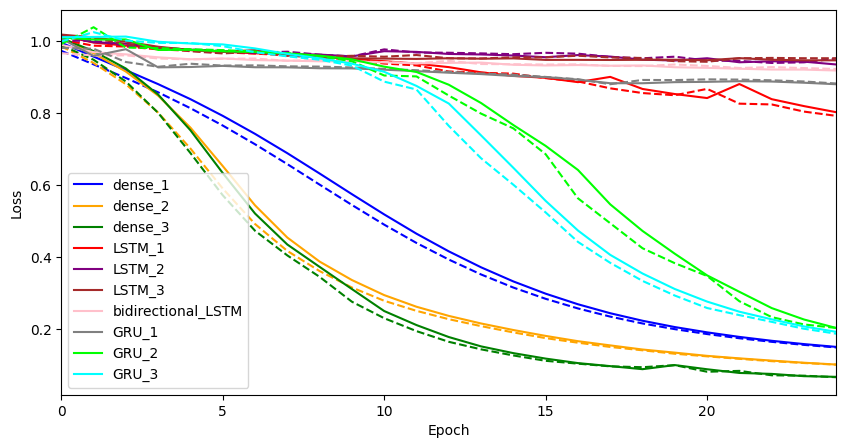

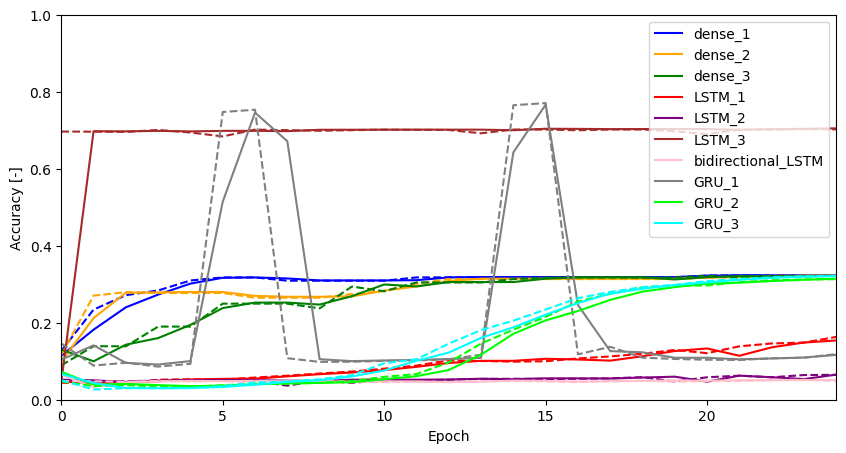

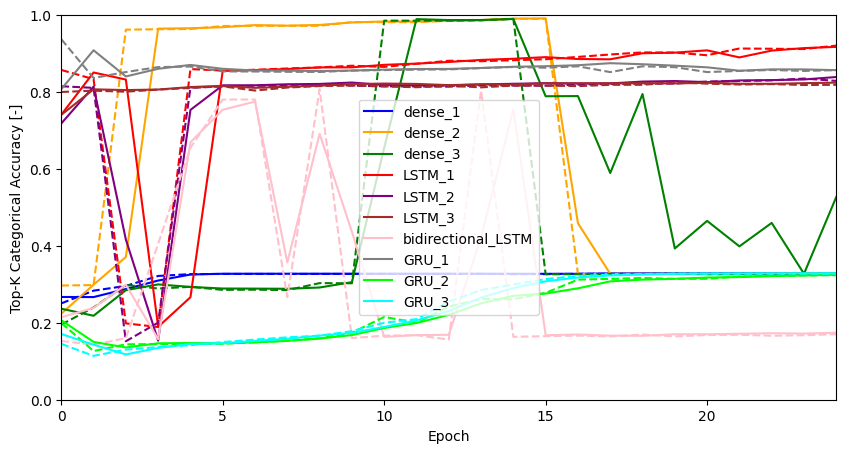

In [21]:
show_plots(results_1, model_names, colors, "merged_1gap")

---
Combine train and test sets with one gap to perform K-Fold.

In [22]:
X_1_gapped = train_1_gapped + test_1_gapped
y_1_full = train_1_full + test_1_full

---
Perfom one-hot encoding on combined datasets, call *perform_kfold* function and display results with *show_kfold_results* function.

In [23]:
models = get_all_models()

X_1 = one_hot_encoding(X_1_gapped)
y_1 = one_hot_encoding(y_1_full)

kfold_1 = perform_kfold(5, X_1, y_1, models, epochs, batch_size)
show_kfold_results(kfold_1, models, model_names)

Model dense_1
Fold 1: 0.3174125850200653
Fold 2: 0.32616788148880005
Fold 3: 0.3301018476486206
Fold 4: 0.32146120071411133
Fold 5: 0.31963470578193665
Mean top k categorical accuracy: 0.32295564413070676

Model dense_2
Fold 1: 0.3306293785572052
Fold 2: 0.32258516550064087
Fold 3: 0.31956446170806885
Fold 4: 0.3239199221134186
Fold 5: 0.31942394375801086
Mean top k categorical accuracy: 0.32322457432746887

Model dense_3
Fold 1: 0.3079720139503479
Fold 2: 0.06519143283367157
Fold 3: 0.022620301693677902
Fold 4: 0.6839480400085449
Fold 5: 0.014752371236681938
Mean top k categorical accuracy: 0.21889683194458484

Model LSTM_1
Fold 1: 0.14923076331615448
Fold 2: 0.23048822581768036
Fold 3: 0.23870740830898285
Fold 4: 0.26315420866012573
Fold 5: 0.2621707022190094
Mean top k categorical accuracy: 0.22875026166439055

Model LSTM_2
Fold 1: 0.05867132917046547
Fold 2: 0.11141552776098251
Fold 3: 0.23561644554138184
Fold 4: 0.26926589012145996
Fold 5: 0.2835265100002289
Mean top k categorical

---
Create a list of all models and train them using *train_models* function, using datasets with three gaps.

In [24]:
models_3 = get_all_models()

results_3 = train_models(models_3, X_train_3, y_train_3, X_test_3, y_test_3, epochs, batch_size, verbose=0)

---
Display plots of loss function, accuracy and top-5 categorical accuracy throughout the training.

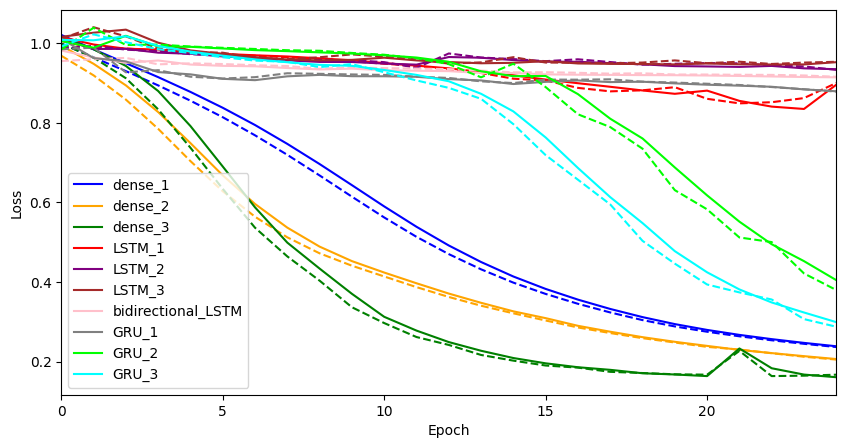

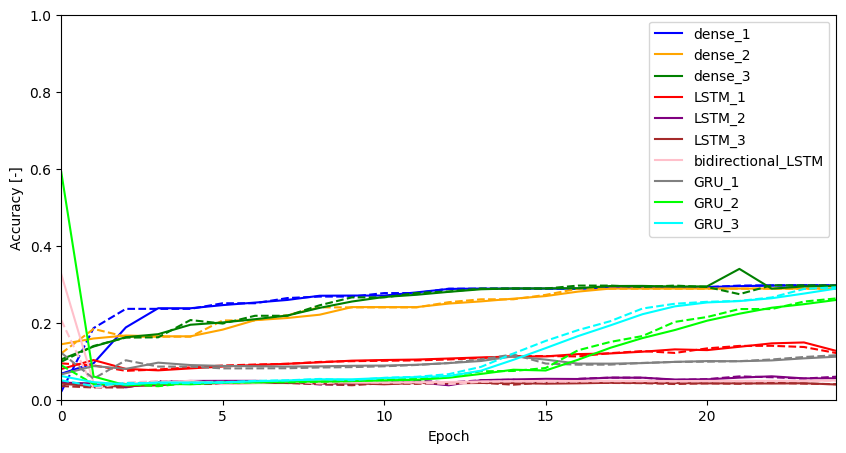

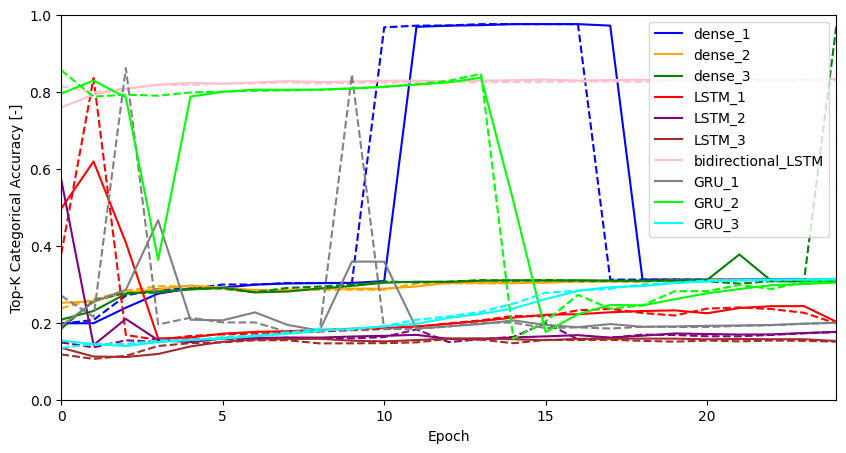

In [25]:
show_plots(results_3, model_names, colors, "merged_3gaps")

---
Combine train and test sets with three gaps to perform K-Fold.

In [26]:
X_3_gapped = train_3_gapped + test_3_gapped
y_3_full = train_3_full + test_3_full

---
Perfom one-hot encoding on combined datasets, call *perform_kfold* function and display results with *show_kfold_results* function.

In [27]:
models = get_all_models()

X_3 = one_hot_encoding(X_3_gapped)
y_3 = one_hot_encoding(y_3_full)

kfold_3 = perform_kfold(5, X_3, y_3, models, epochs, batch_size)
show_kfold_results(kfold_3, models, model_names)

Model dense_1
Fold 1: 0.2988111972808838
Fold 2: 0.29539865255355835
Fold 3: 0.29357218742370605
Fold 4: 0.3024235963821411
Fold 5: 0.29553917050361633
Mean top k categorical accuracy: 0.2971489608287811

Model dense_2
Fold 1: 0.3008391559123993
Fold 2: 0.2963821589946747
Fold 3: 0.30010536313056946
Fold 4: 0.2949771583080292
Fold 5: 0.2927291989326477
Mean top k categorical accuracy: 0.29700660705566406

Model dense_3
Fold 1: 0.2876923084259033
Fold 2: 0.10115911811590195
Fold 3: 0.029645239934325218
Fold 4: 0.07207586616277695
Fold 5: 0.07031963765621185
Mean top k categorical accuracy: 0.11217843405902386

Model LSTM_1
Fold 1: 0.13237762451171875
Fold 2: 0.2152441143989563
Fold 3: 0.2413066327571869
Fold 4: 0.25774499773979187
Fold 5: 0.2543730139732361
Mean top k categorical accuracy: 0.22020927667617798

Model LSTM_2
Fold 1: 0.04489510506391525
Fold 2: 0.058166492730379105
Fold 3: 0.11127502471208572
Fold 4: 0.17506146430969238
Fold 5: 0.2316122204065323
Mean top k categorical acc

---
Create a list of all models and train them using *train_models* function, using datasets with five gaps.

In [28]:
models_5 = get_all_models()

results_5 = train_models(models_5, X_train_5, y_train_5, X_test_5, y_test_5, epochs, batch_size, verbose=0)

---
Display plots of loss function, accuracy and top-5 categorical accuracy throughout the training.

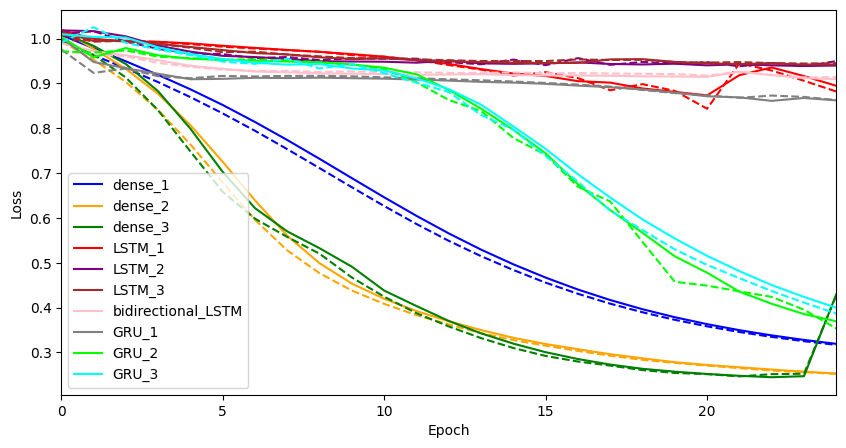

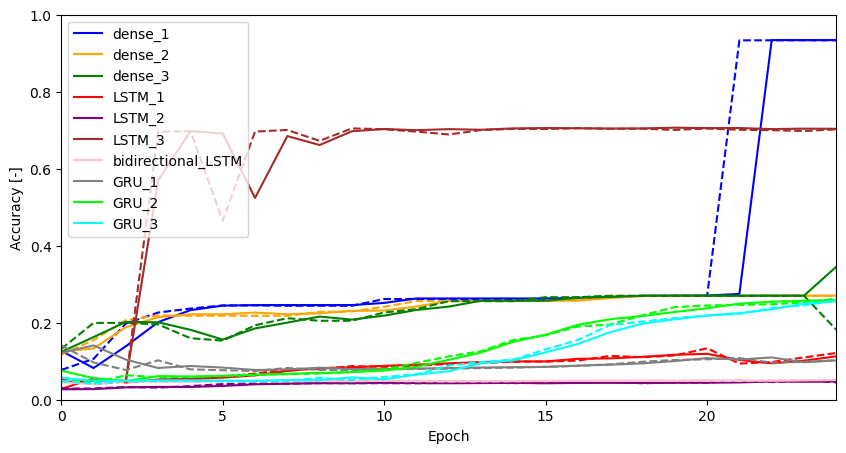

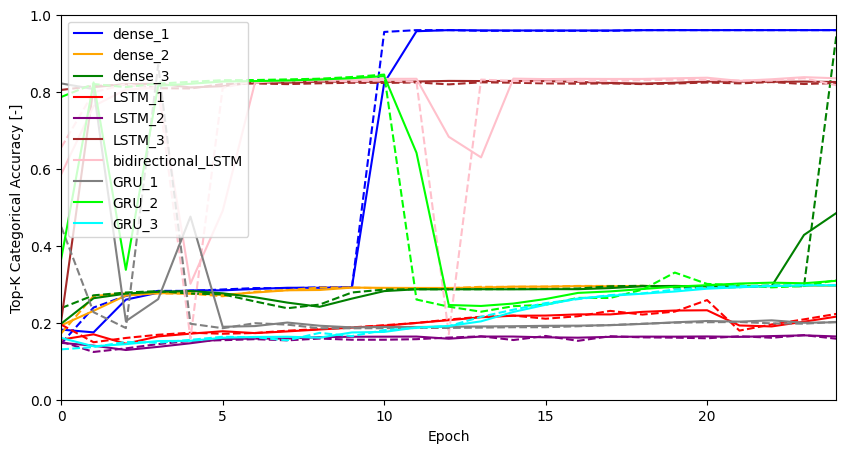

In [29]:
show_plots(results_5, model_names, colors, "merged_5gaps")

---
Combine train and test sets with five gaps to perform K-Fold.

In [30]:
X_5_gapped = train_5_gapped + test_5_gapped
y_5_full = train_5_full + test_5_full

---
Perfom one-hot encoding on combined datasets, call *perform_kfold* function and display results with *show_kfold_results* function.

In [31]:
models = get_all_models()

X_5 = one_hot_encoding(X_5_gapped)
y_5 = one_hot_encoding(y_5_full)

kfold_5 = perform_kfold(5, X_5, y_5, models, epochs, batch_size)
show_kfold_results(kfold_3, models, model_names)

Model dense_1
Fold 1: 0.2988111972808838
Fold 2: 0.29539865255355835
Fold 3: 0.29357218742370605
Fold 4: 0.3024235963821411
Fold 5: 0.29553917050361633
Mean top k categorical accuracy: 0.2971489608287811

Model dense_2
Fold 1: 0.3008391559123993
Fold 2: 0.2963821589946747
Fold 3: 0.30010536313056946
Fold 4: 0.2949771583080292
Fold 5: 0.2927291989326477
Mean top k categorical accuracy: 0.29700660705566406

Model dense_3
Fold 1: 0.2876923084259033
Fold 2: 0.10115911811590195
Fold 3: 0.029645239934325218
Fold 4: 0.07207586616277695
Fold 5: 0.07031963765621185
Mean top k categorical accuracy: 0.11217843405902386

Model LSTM_1
Fold 1: 0.13237762451171875
Fold 2: 0.2152441143989563
Fold 3: 0.2413066327571869
Fold 4: 0.25774499773979187
Fold 5: 0.2543730139732361
Mean top k categorical accuracy: 0.22020927667617798

Model LSTM_2
Fold 1: 0.04489510506391525
Fold 2: 0.058166492730379105
Fold 3: 0.11127502471208572
Fold 4: 0.17506146430969238
Fold 5: 0.2316122204065323
Mean top k categorical acc

---
Display a bar plot with average values of accuracy for different models and number of gaps.

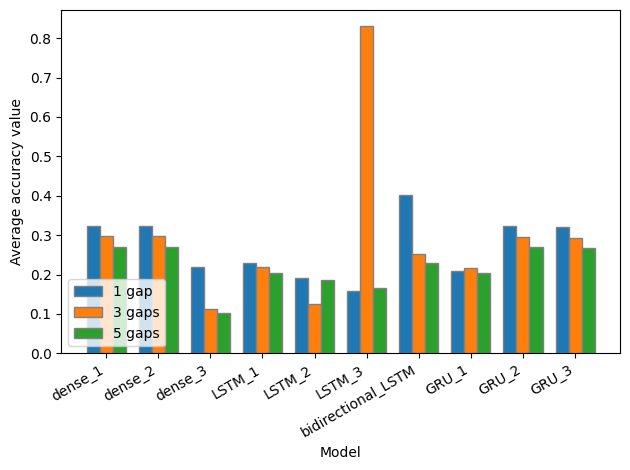

In [33]:
avg_1_accuracy = []
avg_3_accuracy = []
avg_5_accuracy = []

for i, accuracy in enumerate(models):
  avg_1_accuracy.append(np.mean(kfold_1[i]))
  avg_3_accuracy.append(np.mean(kfold_3[i]))
  avg_5_accuracy.append(np.mean(kfold_5[i]))

barWidth = 0.25

br1 = np.arange(len(avg_1_accuracy))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, avg_1_accuracy, color='tab:blue', width = barWidth,
        edgecolor ='grey', label ='1 gap')
plt.bar(br2, avg_3_accuracy, color='tab:orange', width = barWidth,
        edgecolor ='grey', label ='3 gaps')
plt.bar(br3, avg_5_accuracy, color='tab:green', width = barWidth,
        edgecolor ='grey', label ='5 gaps')

plt.xlabel('Model')
plt.ylabel('Average accuracy value')
plt.xticks([r + barWidth for r in range(len(avg_1_accuracy))],
        model_names, rotation=30, ha='right')

plt.tight_layout()
plt.legend(loc='lower left')

plt.savefig("av_accuracy.png")
plt.show()